In [4]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import datetime
import pytz
import matplotlib.pyplot as plt
import preprocessing as prep
from collections import namedtuple
from bb_binary import FrameContainer, Repository, load_frame_container
import numpy as np
import numpy.ma as npma
import datetime
import csv
import seaborn as sns
from collections import Counter
import hatching as ht

In [5]:
%matplotlib inline

In [35]:
sns.set_context("paper")

In [17]:
start = "2016-07-26T16:00:00Z"
start_dt = datetime.datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)
start_ts = start_dt.timestamp()
end_dt = start_dt + datetime.timedelta(minutes=10)
end_ts = end_dt.timestamp()

In [18]:
path = '/storage/mi/aschle/data/'

In [19]:
df0 = prep.getDF(path, start_ts, end_ts, 0)
df1 = prep.getDF(path, start_ts, end_ts, 1)
df2 = prep.getDF(path, start_ts, end_ts, 2)
df3 = prep.getDF(path, start_ts, end_ts, 3)

# Number of Detections and IDS VS confidence level

In [248]:
data = pd.concat([df0,df1,df2,df3])

In [249]:
data.head(1)

,idx,xpos,ypos,radius,zRotation,decodedId,frame_idx,timestamp,cam_id,fc_id,frame_id
0,0,51,1337,22.927212,-0.436176,"[255, 255, 0, 255, 0, 0, 254, 255, 255, 0, 255...",0,1.469549e+09,0,10487780367802891005,9235224632327916253


In [250]:
data = prep.calcIds(data, 0, 2016)

In [37]:
total = data.shape[0]
remaining = []
for i in np.arange(0,1.01, 0.01):
    df = data[data.confidence >= i]
    remaining.append({'conf': i*100, 'remainingDetections': df.shape[0], 'remainingDetectionsP': df.shape[0]/total*100})

In [38]:
plotData = DataFrame(remaining)

In [39]:
plotData.head(2)

,conf,remainingDetections,remainingDetectionsP
0,0.0,1056033,100.000000
1,1.0,1048626,99.298601


In [41]:
total = 4096
remainingIDs = []
for i in np.arange(0,1.01, 0.01):
    df = data[data.confidence >= i]
    ids = len(df.id.unique())
    
    remainingIDs.append({'conf': i*100, 'remainingIds': ids, 'remainingIdsP': ids/total*100})

In [42]:
plotDataIDs = DataFrame(remainingIDs)

In [44]:
plotDataAll = plotData.merge(plotDataIDs,on='conf')

In [45]:
plotDataAll.to_csv('10minNumDetectionsIDsVSconfidence.csv')

In [637]:
plotDataAll.query('conf == 95.0')

,conf,remainingDetections,remainingDetectionsP,remainingIds,remainingIdsP
95,95.0,649382,61.492586,2550,62.255859


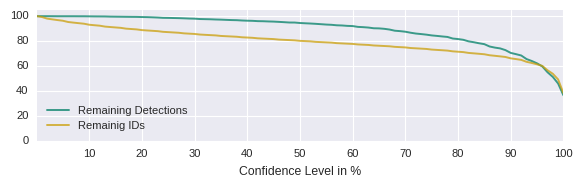

In [122]:
fig, ax = plt.subplots()
ax = plotDataAll.plot(x='conf', y=['remainingIdsP', 'remainingDetectionsP'], alpha=0.75, ax=ax, color=['#007f66', '#cb9f0a'], ylim=(0,105), xlim=(0,100))
ax.set_xlabel('Confidence Level in %')
ax.legend(['Remaining Detections', 'Remainig IDs'], loc=3)
ax.set_xticks([10,20,30,40,50,60,70,80,90,100])
fig.set_size_inches(5.91553, 5.91553/3)
plt.tight_layout()
plt.savefig('confVSids.pdf')

# Age Info

In [86]:
aa = ht.get_all_bees_age(start_dt)



data['age'] = data.id.apply(lambda x: aa.iloc[x].age)

In [88]:
data.head(2)

,idx,xpos,ypos,radius,zRotation,frame_idx,timestamp,cam_id,fc_id,frame_id,confidence,id,age
0,0,51,1337,22.927212,-0.436176,0,1.469549e+09,0,10487780367802891005,9235224632327916253,0.992157,3387,15
1,1,163,1538,22.708023,0.595369,0,1.469549e+09,0,10487780367802891005,9235224632327916253,0.992157,3870,5


In [89]:
remainingDetAge = []
for i in np.arange(0,1.01, 0.01):
    df = data[data.confidence >= i]
    c = i*100
    numDet = df.shape[0]
    wrongs = df[df.age < 0].shape[0]
    remainingDetAge.append({'conf': c, 'detections': numDet, 'wrongDetections': wrongs, 'wrongDetectionsP': (wrongs*2)/numDet*100})

In [90]:
plotDataDetAge = DataFrame(remainingDetAge)

In [91]:
plotDataDetAge.tail(2)

,conf,detections,wrongDetections,wrongDetectionsP
99,99.0,521895,6327,2.424626
100,100.0,406432,3694,1.817770


In [92]:
total = 4096
remainingIDsAge = []

for i in np.arange(0,1.01, 0.01):
    df = data[data.confidence >= i]
    ids = DataFrame(df.id.unique(), columns=['id'])
    ids['age'] = ids.id.apply(lambda x: aa.iloc[x].age)
    
    numIDs = ids.shape[0]
    wrongs = ids[ids.age < 0].shape[0]
    
    remainingIDsAge.append({'conf': i*100, 'IDs': numIDs, 'wrongIds': wrongs, 'wrongIdsP':  (wrongs)/numIDs*100})

In [93]:
plotDataIDsAge = DataFrame(remainingIDsAge)

In [94]:
plotDataAllAge = plotDataDetAge.merge(plotDataIDsAge,on='conf')

In [636]:
plotDataAllAge.query('conf == 95.0')

,conf,detections,wrongDetections,wrongDetectionsP,IDs,wrongIds,wrongIdsP
95,95.0,649382,12462,3.838111,2550,1375,53.921569


In [97]:
plotDataAllAge.to_csv('10minNumDetectionsIDsVSconfidenceAGE.csv')

In [99]:
allall = plotDataAllAge.merge(plotDataAll, on='conf')

In [127]:
tot = 1056033

In [146]:
allall['DET'] = (allall.detections - allall.wrongDetections)/tot*100

In [147]:
allall['DETWRONG'] = allall.wrongDetections/tot*100

In [193]:
totid = 4096

In [194]:
allall['IDS'] = (allall.IDs - allall.wrongIds)/totid*100

In [195]:
allall['IDSWRONG'] = allall.wrongIds/totid*100

In [148]:
allall.head()

,conf,detections,wrongDetections,wrongDetectionsP,IDs,wrongIds,wrongIdsP,remainingDetections,remainingDetectionsP,remainingIds,remainingIdsP,DET,DETWRONG
0,0.0,1056033,149620,28.336236,4093,2080,50.818471,1056033,100.000000,4093,99.926758,85.831882,14.168118
1,1.0,1048626,145837,27.814874,4093,2080,50.818471,1048626,99.298601,4093,99.926758,85.488711,13.809890
2,2.0,1034777,138727,26.812927,4093,2080,50.818471,1034777,97.987184,4093,99.926758,84.850568,13.136616
3,3.0,1028480,135407,26.331479,4092,2080,50.830890,1028480,97.390896,4092,99.902344,84.568664,12.822232
4,4.0,1022431,132402,25.899449,4091,2080,50.843315,1022431,96.818092,4091,99.877930,84.280415,12.537676


In [240]:
allall.to_csv('allallConfPlotData.csv')

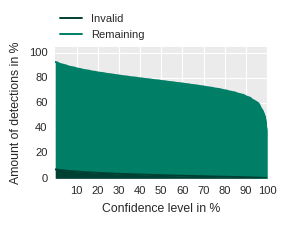

In [675]:
sns.set_style("darkgrid", {"axes.facecolor": "#ebebeb"})
fig, ax = plt.subplots()
fig.set_size_inches(5.91553/2, 5.91553/3)
allall['newdetwrong'] = allall.DETWRONG/2
ax = allall.plot(x='conf', y=['DET', 'newdetwrong'][::-1], kind='area', ax=ax, color=['#007f66', '#004033'][::-1], ylim=(0,105))
ax.set_xlabel('Confidence level in %')
ax.set_ylabel('Amount of detections in %')
ax.set_xticks([10,20,30,40,50,60,70,80,90,100])

#legend = ax.legend(['Remaining detections', 'Wrong detections'], loc=3, )
#frame = legend.get_frame()
#frame.set_facecolor('#00FFCC')

lgd = plt.legend(['Remaining', 'Invalid'][::-1], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, borderaxespad=0.)

plt.tight_layout()
fig.savefig('detectionsWrongConf.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
#plt.savefig('detectionsWrongConf.pdf')

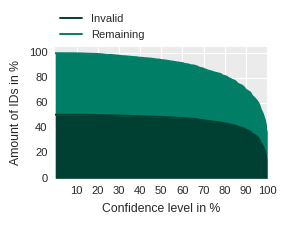

In [676]:
sns.set_style("darkgrid", {"axes.facecolor": "#ebebeb"})
fig, ax = plt.subplots()
fig.set_size_inches(5.91553/2, 5.91553/3)

ax = allall.plot(x='conf', y=['IDS', 'IDSWRONG'][::-1], kind='area', ax=ax, color=['#007f66', '#004033'][::-1], ylim=(0,105))
ax.set_xlabel('Confidence level in %')
ax.set_ylabel('Amount of IDs in %')
ax.set_xticks([10,20,30,40,50,60,70,80,90,100])

lgd = plt.legend(['Remaining', 'Invalid'][::-1], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, borderaxespad=0.)

plt.tight_layout()
#plt.savefig('idsWrongConf.pdf')
fig.savefig('idsWrongConf.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [236]:
dffrequency = DataFrame(data[data.confidence >= 0.95].groupby(by='id').size(), columns=['frequency']).reset_index()
dffrequency['age'] = dffrequency.id.apply(lambda x: aa.iloc[x].age)

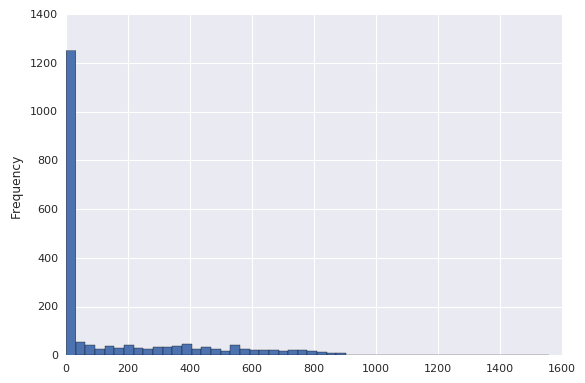

In [436]:
dffrequency.frequency.plot.hist(bins=50)

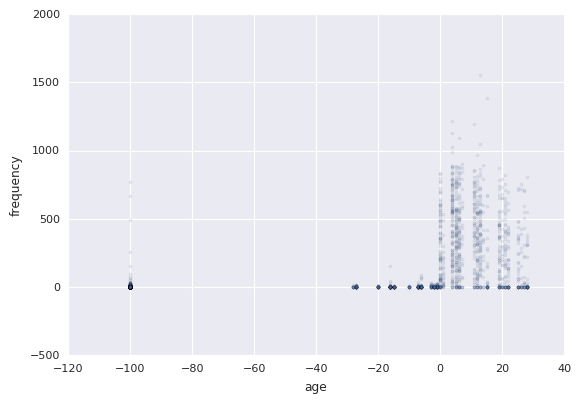

In [237]:
dffrequency.plot.scatter(x='age', y='frequency', s=5, alpha=0.1)

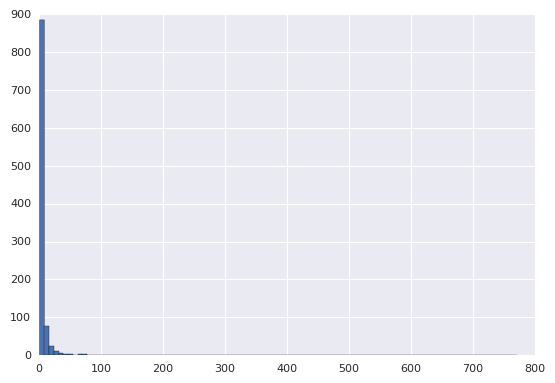

In [238]:
dffrequency[dffrequency.age < 0].frequency.hist(bins=100)#mean()

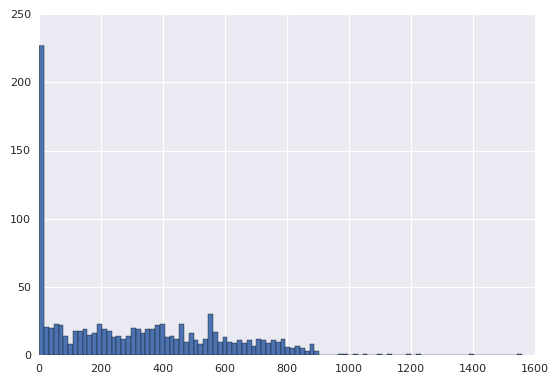

In [239]:
dffrequency[dffrequency.age >= 0].frequency.hist(bins=100) #mean()

In [219]:
dffrequency.frequency.mean()

159.34827082318557

In [220]:
310.5/7.2

43.125

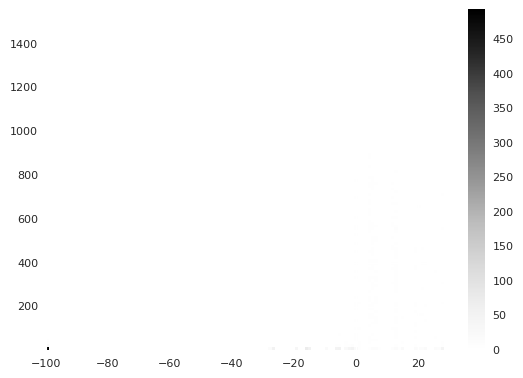

In [221]:
H, xedges, yedeges, im = plt.hist2d(dffrequency.age,dffrequency.frequency,bins=[120,120])
plt.colorbar()

# Average Number of Gaps per Bee Series depending on Confidence Level

In [251]:
data0 = data[data.cam_id == 0]

In [252]:
data.head()

,idx,xpos,ypos,radius,zRotation,frame_idx,timestamp,cam_id,fc_id,frame_id,confidence,id
0,0,51,1337,22.927212,-0.436176,0,1.469549e+09,0,10487780367802891005,9235224632327916253,0.992157,3387
1,1,163,1538,22.708023,0.595369,0,1.469549e+09,0,10487780367802891005,9235224632327916253,0.992157,3870
2,2,189,2626,23.293472,0.364826,0,1.469549e+09,0,10487780367802891005,9235224632327916253,0.011765,1607
3,3,202,924,22.790953,0.147058,0,1.469549e+09,0,10487780367802891005,9235224632327916253,0.992157,1854
4,4,201,1990,23.085573,0.218766,0,1.469549e+09,0,10487780367802891005,9235224632327916253,0.050980,541


In [604]:
def get_gaps_length(kette):
    kette = kette.apply(str)
    s = kette.str.cat(sep='')
    s = s.strip("0")
    ss = s.split('1')
    return [len(x) for x in ss if len(x) > 0]

In [612]:
def get_num_of_gaps(kette):
    kette = kette.apply(str)
    s = kette.str.cat(sep='')
    s = s.strip("0")
    ss = s.split('1')
    return len([len(x) for x in ss if len(x) > 0])

In [255]:
statGapS = []
for i in np.arange(0,1.01, 0.01)[[0,10,20,30,40,50,60,70,80,85,90,91,92,93,94,95,96,97,98,99,100]]:
    dd = data[data.confidence >= i]
    dft = prep.df_to_timeseries(dd)
    gapsLen = dft.apply(get_gaps_length, axis=1)
    flattened = [n for elem in gapsLen for n in elem]
    sL = Series(flattened)
 
    gapsNum = dft.apply(get_num_of_gaps, axis=1)
    s = Series(gapsNum)
    
    s0 = dft.shape[1] - Series(dft.sum(axis=1))
    
    statGapS.append({'conf': i, 'LenMean': sL.mean(), 'LenMedian': sL.median(), 'NumMean': s.mean(), 'NumMedian': s.median(),'total': dft.shape[0], \
                    'total0': s0.sum(), 's0mean': s0.mean(), 's0median': s0.median()})

In [256]:
dfGAPS = DataFrame(statGapS)
dfGAPS.conf *= 100

In [257]:
dfGAPS.to_csv('gapsPlotData.csv')

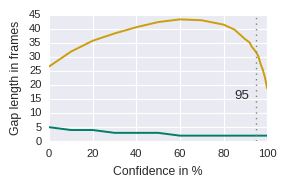

In [289]:
fig, ax = plt.subplots()
dfGAPS.plot(x="conf", y=["LenMedian", "LenMean"], color=['#007f66', '#cb9f0a'], ax=ax, legend=False)
fig.set_size_inches(5.91553/2,5.91553/3)

ax.set_ylabel("Gap length in frames")
ax.set_xlabel("Confidence in %")
plt.axvline(95, color='0.5', linestyle='dotted', linewidth=1)
plt.text(85,15,'95',rotation=0)
plt.tight_layout()

#lgd = plt.legend(["Median", "Mean"], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, borderaxespad=0.)
#fig.savefig('gaplen.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig('gaplen.pdf')

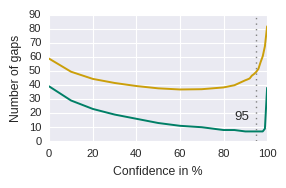

In [290]:
fig, ax = plt.subplots()
dfGAPS.plot(x="conf", y=["NumMedian", "NumMean"], color=['#007f66', '#cb9f0a'],ax=ax, legend=False)
fig.set_size_inches(5.91553/2,5.91553/3)

ax.set_ylabel("Number of gaps")
ax.set_xlabel("Confidence in %")
plt.axvline(95, color='0.5', linestyle='dotted', linewidth=1)
plt.text(85,15,'95',rotation=0)
plt.tight_layout()
#lgd = plt.legend(["Median", "Mean"], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, borderaxespad=0.)
#fig.savefig('numgaps.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig('numgaps.pdf')

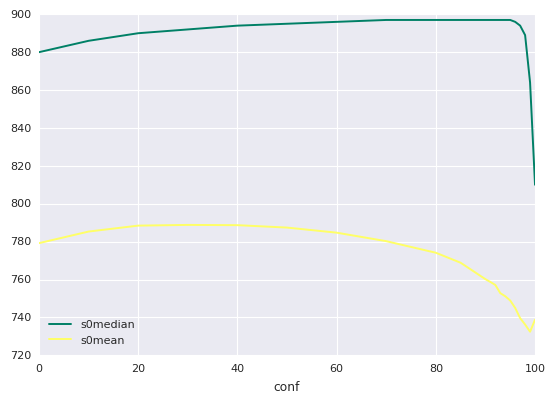

In [429]:
dfGAPS.plot(x="conf", y=["s0median", "s0mean"], colormap="summer")

# Average Number of Gaps in Pair Time Series

In [592]:
data1 = data[data.cam_id == 1]

In [631]:
statPairs = []
for i in np.arange(0,1.01, 0.01):            
    dd = data1[data1.confidence >= i]
    dftpairs = prep.get_close_bees_ckd(dd, 212)
    dftpairs = prep.bee_pairs_to_timeseries(dftpairs)
    
    # Gap Length
    gapsLen = dftpairs.apply(get_gaps_length, axis=1)
    meanGapLength = gapsLen.apply(lambda x: Series(x).mean()).mean()
    flattened = Series([n for elem in gapsLen for n in elem])   
    medianGapLength = flattened.median()
    
    # Number of Gaps
    gapsNum = dftpairs.apply(get_num_of_gaps, axis=1)
    meanNumberOfGaps = gapsNum.mean()
    medianNumberOfGaps = gapsNum.median()
    statPairs.append({"confidence": i,
                      "meanGapLength": meanGapLength,
                      'medianGapLength': medianGapLength,
                      "meanNumberOfGaps": meanNumberOfGaps,
                      'medianNumberOfGaps': medianNumberOfGaps})

In [632]:
statPairs = DataFrame(statPairs)

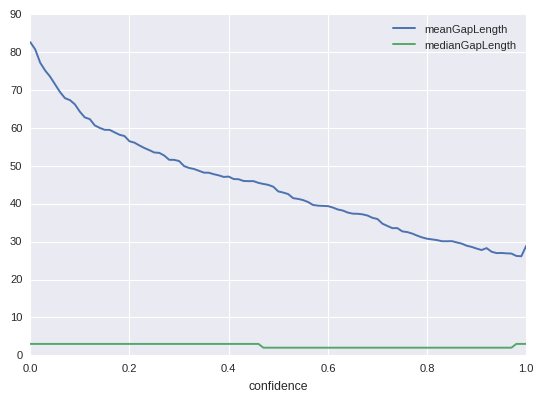

In [634]:
statPairs.plot(x='confidence', y=['meanGapLength', 'medianGapLength'])

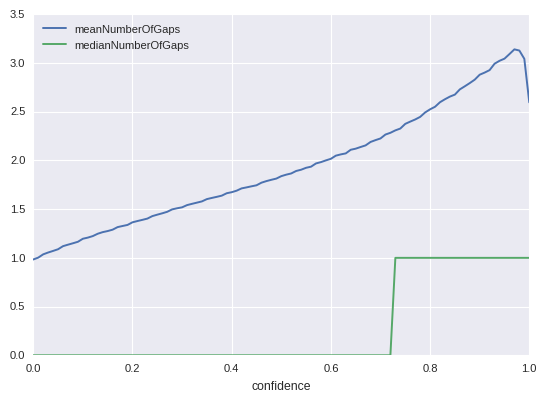

In [635]:
statPairs.plot(x='confidence', y=['meanNumberOfGaps','medianNumberOfGaps'])

In [620]:
100*10/6/60

2.7777777777777777

In [ ]:
    gapsLen = dft.apply(get_gaps_length, axis=1)
    flattened = [n for elem in gapsLen for n in elem]
    sL = Series(flattened)
 
    gapsNum = dft.apply(get_num_of_gaps, axis=1)
    s = Series(gapsNum)
    
    s0 = dft.shape[1] - Series(dft.sum(axis=1))
    
    statGapS.append({'conf': i, 'LenMean': sL.mean(), 'LenMedian': sL.median(), 'NumMean': s.mean(), 'NumMedian': s.median(),'total': dft.shape[0], \
                    'total0': s0.sum(), 's0mean': s0.mean(), 's0median': s0.median()})

In [368]:
testdf = DataFrame([[1,2,3],[3,4,5],[3,4,5]])

In [369]:
testdf

,0,1,2
0,1,2,3
1,3,4,5
2,3,4,5


In [371]:
testdf.sum(axis=1)

0     6
1    12
2    12
dtype: int64

# Histogramm: Frequency of Detection per ID: conf = 95

In [294]:
freq = pd.read_csv('ID_frequencies_2016-08-20_95conf_24h.csv', names=['id', 'freq'])

In [296]:
24*60*60*3.5

302400.0

In [306]:
start = "2016-08-20T16:00:00Z"
start_dt = datetime.datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)

In [307]:
aa = ht.get_all_bees_age(start_dt)
freq['age'] = freq.id.apply(lambda x: aa.iloc[x].age)

In [308]:
freq.head()

,id,freq,age
0,0,51,-100
1,1,353,23
2,2,11,-100
3,3,148,45
4,4,14,-2


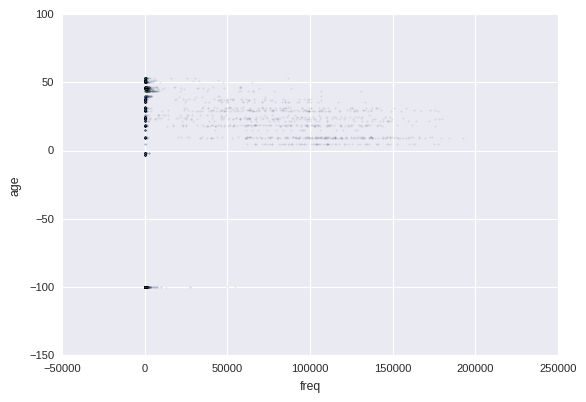

In [310]:
freq[freq.age<200].plot.scatter(y='age', x='freq', s=1, alpha=0.1)

In [503]:
dataPos = freq[freq.age >= 0].freq
dataNeg = (freq[freq.age < 0].freq)

In [505]:
len(dataNeg)

1084

In [506]:
len(dataPos)

3012

In [507]:
listeNeg = dataNeg[dataNeg > 10000]

In [508]:
remove = [17,155,2045,2357,3103]

In [509]:
dataNeg = freq[~freq.id.isin(remove)][freq.age < 0].freq

/home/mi/aschle/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [510]:
len(dataNeg)

1079

In [555]:
binn=80

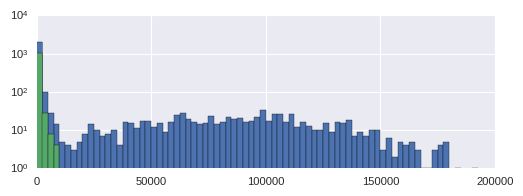

In [556]:
fig, ax = plt.subplots()
fig.set_size_inches(5.91553,5.91553/3)
sns.set_style('darkgrid')
sns.set_context("paper")
ax.set_yscale('log')

a = plt.hist([dataPos], bins=binn, range=(0,200000))
b = plt.hist([dataNeg], bins=binn, range=(0,200000))

In [557]:
posi = list(Series(a[0]))

In [558]:
neg = list(Series(b[0]))

In [559]:
negi = list((Series(b[0]))*(-1))

In [560]:
x = range(len(posi))
negative_data = [int(i) for i in list(negi)]
positive_data = [int(i) for i in list(posi)]

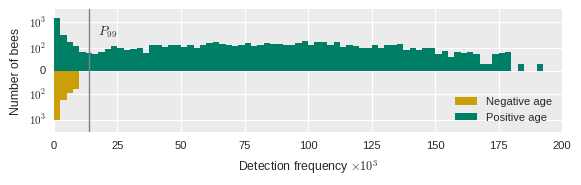

In [678]:
from matplotlib.ticker import ScalarFormatter

fig = plt.figure()
fig.set_size_inches(5.91553,5.91553/3)
sns.set_style("darkgrid", {"axes.facecolor": "#ebebeb"})

sns.set_context("paper")
ax = plt.subplot()
ax.set_yscale('symlog')
ecolor= 'white'
lw = 0
al = 1
ax.axvline(np.percentile(dataNeg, q=99)/1000, linewidth=1, color='0.5', linestyle='solid', alpha=al)
aa = ax.bar(x, negative_data, width=1, color='#CB9F0A', alpha=al, edgecolor=ecolor, linewidth=lw)
bb = ax.bar(x, positive_data, width=1, color='#007f66', alpha=al, edgecolor=ecolor, linewidth=lw)
ax.set_ylabel('Number of bees')

ax.set_yticks([-1000, -10, 0,10,1000])
ax.text(7,100, r'$P_{99}$')


ax.set_xticklabels([int(int(i)/1000) for i in a[1][::10]])
ax.set_yticklabels(['$10^3$','$10^2$','0','$10^2$','$10^3$'])
ax.set_xlabel(r'Detection frequency $\times 10^3$')
fig.tight_layout()

lgd = plt.legend([aa,bb], ['Negative age', 'Positive age'], loc=4)

# 'xfmt = ScalarFormatter(useMathText=True)
# xfmt.set_powerlimits((0,0))
# #xfmt.set_useOffset(10)
# ax'.xaxis.set_major_formatter(xfmt)
plt.savefig('filter.pdf', dpi=300, bbox_inches='tight')

In [523]:
binn=50

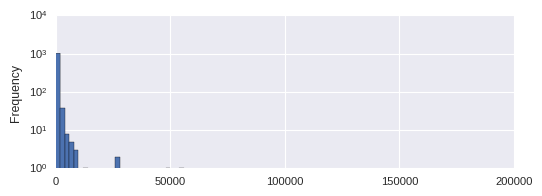

In [524]:
fig, ax = plt.subplots()
fig.set_size_inches(5.91553,5.91553/3)
sns.set_style('darkgrid')
sns.set_context("paper")
ax.set_yscale('log')
freq[freq.age<0].freq.plot.hist(bins=100, ax=ax, range=(0,200000))

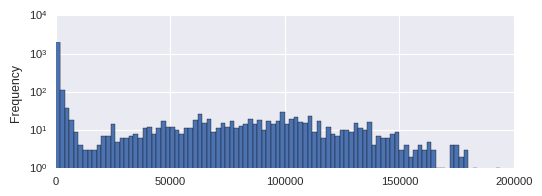

In [334]:
fig, ax = plt.subplots()
fig.set_size_inches(5.91553,5.91553/3)
sns.set_style('darkgrid')
sns.set_context("paper")
ax.set_yscale('log')
freq[freq.age>=0].freq.plot.hist(bins=100, ax=ax, range=(0,200000))